# **Task 1 | Mask Recognition**

***Goal :*** *Detect human faces on videos and check whether or not they have a mask on*. 

In this notebook we implement three models different model to perform the task :
- RCNN ResNet50

___
___

## **1. INITIALIZATION**

### *1.1 IMPORTS*

In [2]:
from IPython.display import display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from xml.dom import minidom

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random as rd
import time
import wget

from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import torch
import torch.nn as nn

In [3]:
# to fill the `requirement.txt` file we use the following line of code:
import session_info
session_info.show()

In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: {}".format(device))

device: cuda


### *1.2. DATA LOADING*

In [5]:
data_root_dir = "data/FaceMaskDetection/"           # path to the directory with the relevant data
annotations_dir = data_root_dir + "annotations/"    # path to the directory with the .xml annotations files
images_dir = data_root_dir + "images/"              # path to the directory with the images

annotation_files = os.listdir(annotations_dir)      # list of the files in the annotation directory
annotation_files.sort()

image_files = os.listdir(images_dir)                # list of files in the image directory
image_files.sort()

In [6]:
# 1st check-point: same number of files and same file ids in the same order
assert ([annotation_file[15:-4] for annotation_file in annotation_files] == [image_file[15:-4] for image_file in image_files])

In [7]:
# to have all the annotations files in the same pandas dataframe (easier to manipulate)
def get_annotations(data_root_dir, annotations_dir, annotation_files):

    # if the dataframe has already been computed and saved as a .csv file
    if "annotations.csv" in os.listdir(data_root_dir):
        annotations = pd.read_csv(data_root_dir + "annotations.csv", index_col=None)

    # else, we compute and save it
    else:

        data = []
        mask_label = {"without_mask": 0, "mask_weared_incorrect": 0, "with_mask": 1}

        for i in tqdm(range(len(annotation_files))):
    
            annotation = minidom.parse(annotations_dir + annotation_files[i])
            
            image_id = int(annotation.getElementsByTagName("filename")[0].firstChild.data[12:-4])
            image_height = int(annotation.getElementsByTagName("height")[0].firstChild.data)
            image_width = int(annotation.getElementsByTagName("width")[0].firstChild.data)
        
            for box_id,object in enumerate(annotation.getElementsByTagName("object")):

                box_label = mask_label[object.getElementsByTagName("name")[0].firstChild.data]
                xmin = int(object.getElementsByTagName("xmin")[0].firstChild.data)
                xmax = int(object.getElementsByTagName("xmax")[0].firstChild.data)
                ymin = int(object.getElementsByTagName("ymin")[0].firstChild.data)
                ymax = int(object.getElementsByTagName("ymax")[0].firstChild.data)

                data.append((image_id, image_height, image_width, box_id, box_label, xmin, xmax, ymin, ymax))
        
        columns = ["image_id", "image_height", "image_width", "box_id", "box_label", "xmin", "xmax", "ymin", "ymax"]
        annotations = pd.DataFrame(data=data, columns=columns, index=None)
        annotations.to_csv(data_root_dir + "annotations.csv", index=None)

    return annotations

In [8]:
annotations = get_annotations(data_root_dir, annotations_dir, annotation_files)
display(annotations)

,image_id,image_height,image_width,box_id,box_label,xmin,xmax,ymin,ymax,train
0,0,366,512,0,0,79,109,105,142,True
1,0,366,512,1,1,185,226,100,144,True
2,0,366,512,2,0,325,360,90,141,True
3,1,156,400,0,1,321,354,34,69,True
4,1,156,400,1,1,224,261,38,73,False
...,...,...,...,...,...,...,...,...,...,...
4067,98,267,400,2,1,263,287,62,85,True
4068,98,267,400,3,1,344,377,80,106,True
4069,99,267,400,0,0,181,273,54,162,True
4070,99,267,400,1,1,99,176,87,165,True


In [9]:
class FaceMaskDataset(Dataset):

    def __init__(self, annotations, imgs_dir):
        self.annotations = annotations
        self.img_dir = imgs_dir
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img = plt.imread(self.img_dir+"maksssksksss{}.png".format(int(self.annotations.iloc[idx]["image_id"])))[:,:,:3]
        xmin = self.annotations.iloc[idx]["xmin"]
        xmax = self.annotations.iloc[idx]["xmax"]
        ymin = self.annotations.iloc[idx]["ymin"]
        ymax = self.annotations.iloc[idx]["ymax"]
        img = transforms.Resize((64,64))(torch.Tensor(img[ymin:ymax,xmin:xmax]).permute(2,0,1))
        label = torch.Tensor([int(self.annotations.iloc[idx]["box_label"])])
        return img, label

90% of the whole dataset is dedicated to training and the 10% left is used as a test dataset.

To ensure that we keep the same elements within the two datasets, even after restarting the notebook, we add add a train column to the annotation_dataframe.

In [10]:
if "train" not in annotations:

    train_size = int(0.90*len(annotations))
    train_ids = rd.sample(range(len(annotations)), train_size)
    annotations["train"] = [i in train_ids for i in range(len(annotations))]
    annotations.to_csv(data_root_dir + "annotations.csv", index=None)

train_dataset = FaceMaskDataset(annotations[annotations["train"]], images_dir)
test_dataset = FaceMaskDataset(annotations[annotations["train"] == False], images_dir)

batch_size = 128

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

To [train the YOLO model](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data) we need to format our data as it follows:

In [11]:
def get_yolo_labels(annotations, data_root_dir):

    if "labels" not in os.listdir(data_root_dir):
        os.mkdir(data_root_dir + "labels")
    
    annotations_ids = list(set(annotations["image_id"]))
    annotations_ids.sort()

    for i in tqdm(range(len(annotations_ids))):

        image_id = annotations_ids[i]
        indexes = list(annotations[annotations["image_id"] == image_id].index)

        label_file_lines = []

        for index in indexes:

            box_label = annotations.iloc[index]["box_label"]

            image_height, image_width = annotations[["image_height", "image_width"]].iloc[index]
            xmin,  xmax, ymin, ymax = annotations[["xmin", "xmax", "ymin", "ymax"]].iloc[index]

            box_xcenter = ((xmin + xmax)/2)/image_width
            box_ycenter = ((ymin + ymax)/2)/image_height
            box_width = (xmax - xmin)/image_width
            box_height = (ymax - ymin)/image_height

            label_file_lines.append(' '.join([str(box_label), str(box_xcenter), str(box_ycenter), str(box_width), str(box_height)]))
        
        with open(data_root_dir + "labels/maksssksksss{}.txt".format(image_id), 'w') as f:
            f.writelines('\n'.join(label_file_lines))
            f.close()
    
    return data_root_dir + "labels", os.listdir(data_root_dir + "labels")

In [12]:
yolo_data_dir, yolo_data_files = get_yolo_labels(annotations, data_root_dir)
yolo_data_files.sort()

100%|██████████| 853/853 [00:04<00:00, 199.39it/s]


___

## **2. THE MODELS**

### *2.1 ResNet18 & ResNet50*

#### Defining the models

In [13]:
modelRSN18 = models.resnet18(pretrained=True)
for param in modelRSN18.parameters():
    param.requires_grad = False
modelRSN18.fc = nn.Sequential(
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Linear(256,64),
    nn.ReLU(),
    nn.Linear(64,1),
    nn.Sigmoid())

modelRSN18.to(device)
modelRSN18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
modelRSN50 = models.resnet50(pretrained=True)
for param in modelRSN50.parameters():
    param.requires_grad = False
modelRSN50.fc = nn.Sequential(
    nn.Linear(2048,1024),
    nn.ReLU(),
    nn.Linear(1024,256),
    nn.ReLU(),
    nn.Linear(256,1),
    nn.Sigmoid())

modelRSN50.to(device)
modelRSN50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
def train_model(model, criterion, optimizer, nb_epochs, epoch_print_frequence):

    s = time.time()

    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    for epoch in range(nb_epochs):

        running_loss_train, running_loss_test, running_acc_train, running_acc_test = 0,0,0,0

        for train in [True, False]:

            if train:
                dataloader = train_dataloader
                model.train()
            else:
                dataloader = test_dataloader
                model.eval()

            for inputs,labels in dataloader:

                inputs = inputs.to(device)
                labels = labels.to(device)

                if train:
                    optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                if train:
                    loss.backward()
                    optimizer.step()
                    running_loss_train += loss.item()
                    running_acc_train += np.sum(labels.cpu().detach().numpy() == np.round(outputs.cpu().detach().numpy())) 
                    
                else:
                    running_loss_test += loss.item()
                    running_acc_test += np.sum(labels.cpu().detach().numpy() == np.round(outputs.cpu().detach().numpy())) 

        running_loss_train /= len(train_dataloader)
        running_loss_test /= len(test_dataloader)
        running_acc_train /= len(train_dataset)
        running_acc_test /= len(test_dataset)

        train_losses.append(running_loss_train)
        test_losses.append(running_loss_test)
        train_accuracies.append(running_acc_train)
        test_accuracies.append(running_acc_test)

        if (epoch+1) % epoch_print_frequence == 0:
            print("epochs {} ({} s) | train loss : {} | test loss : {} | train acc : {} | test acc : {}".format(
                epoch+1,
                int(time.time()-s),
                int(1000000*running_loss_train)/1000000,
                int(1000000*running_loss_test)/1000000,
                int(1000000*running_acc_train)/1000000,
                int(1000000*running_acc_test)/1000000)
            )
    
    return train_losses, test_losses, train_accuracies, test_accuracies

In [16]:
optimizerRSN18 = torch.optim.Adam(modelRSN18.parameters(), lr=1e-3)
optimizerRSN50 = torch.optim.Adam(modelRSN50.parameters(), lr=1e-3)

criterionRSN18 = nn.BCELoss().cuda()
criterionRSN50 = nn.BCELoss().cuda()

nb_epochs, epoch_print_frequence = 20, 4

In [57]:
resultsRSN18 = train_model(modelRSN18, criterionRSN18, optimizerRSN18, nb_epochs, epoch_print_frequence)
torch.save(modelRSN18.state_dict(), "./models/MaskRecognitionRSN18.pt")

epochs 4 (219 s) | train loss : 0.243451 | test loss : 0.327736 | train acc : 0.906386 | test acc : 0.911764
epochs 8 (445 s) | train loss : 0.150922 | test loss : 0.271852 | train acc : 0.942685 | test acc : 0.879901


In [ ]:
resultsRSN50 = train_model(modelRSN50, criterionRSN50, optimizerRSN50, nb_epochs, epoch_print_frequence)
torch.save(modelRSN50.state_dict(), "./models/MaskRecognitionRSN50.pt")

Error: Session cannot generate requests

#### testing the models

In [17]:
modelRSN18 = models.resnet18(pretrained=True)
for param in modelRSN18.parameters():
    param.requires_grad = False
modelRSN18.fc = nn.Sequential(
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Linear(256,64),
    nn.ReLU(),
    nn.Linear(64,1),
    nn.Sigmoid())

modelRSN18.to(device)
modelRSN18.load_state_dict(torch.load("./models/MaskRecognitionRSN18.pt"))
modelRSN18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
modelRSN50 = models.resnet50(pretrained=True)
for param in modelRSN50.parameters():
    param.requires_grad = False
modelRSN50.fc = nn.Sequential(
    nn.Linear(2048,1024),
    nn.ReLU(),
    nn.Linear(1024,256),
    nn.ReLU(),
    nn.Linear(256,1),
    nn.Sigmoid())

modelRSN50.to(device)
modelRSN50.load_state_dict(torch.load("./models/MaskRecognitionRSN50.pt"))
modelRSN50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
FaceDetection_model_frontal = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
FaceDetection_model_profile = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_profileface.xml")

def detectFaces(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return FaceDetection_model_profile.detectMultiScale(gray_img, 1.1, 4)

In [25]:
def show_random_results(model, nb_images):

    img_ids = rd.sample(list(annotations["image_id"]), nb_images)

    for img_id in img_ids:

        img = cv2.imread(images_dir + "/maksssksksss{}.png".format(img_id))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        overlay = img.copy()
        output = img.copy()

        boxes = detectFaces(img)

        for (xmin,ymin,w,h) in boxes:
            
            xmax = xmin + w
            ymax = ymin + h
            img_tensor = transforms.Resize((64,64))(torch.Tensor(img[ymin:ymax,xmin:xmax]).permute(2,0,1))
            img_tensor = img_tensor.reshape((1,3,64,64)).to(device)
            pred = torch.round(model(img_tensor)).item()

            if pred == 0:
                cv2.rectangle(overlay, (xmin,ymin), (xmax,ymax), (255,0,0), 2)
            
            else:
                cv2.rectangle(overlay, (xmin,ymin), (xmax,ymax), (0,255,0), 2)
            
            output = cv2.addWeighted(overlay, 0.5, output, 0.95, 0, output)
                
        plt.figure(figsize=(15,9))
        plt.imshow(output)
        plt.show()

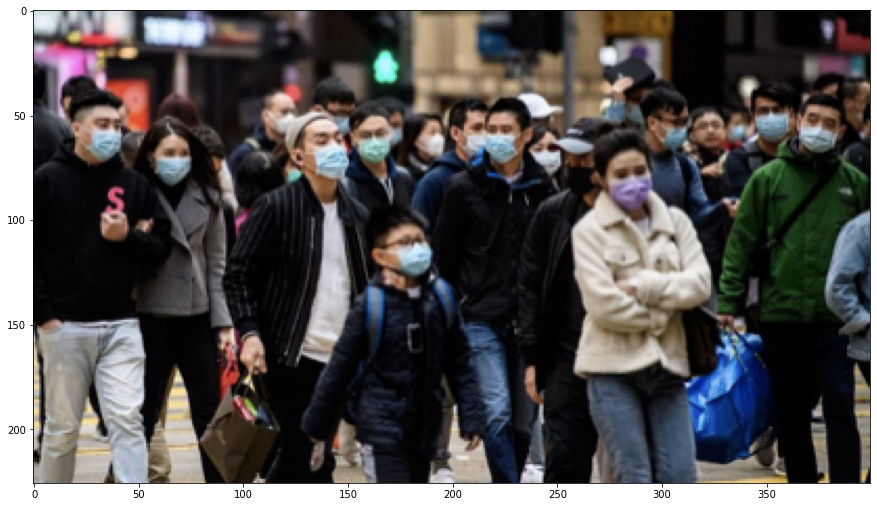

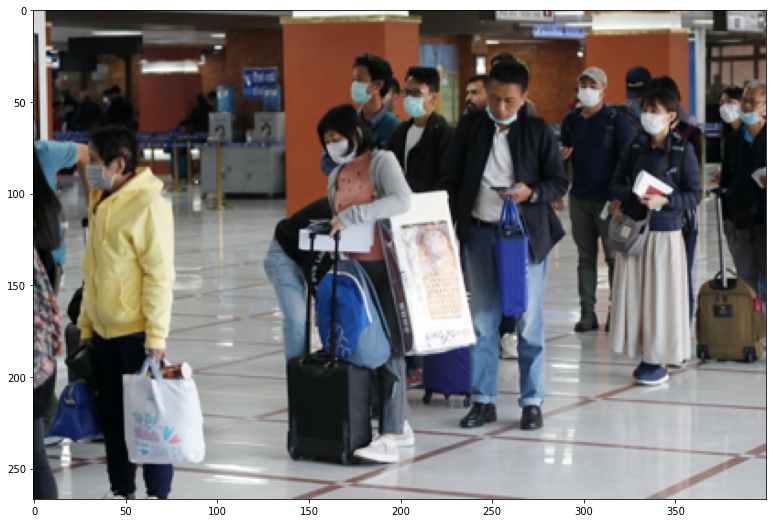

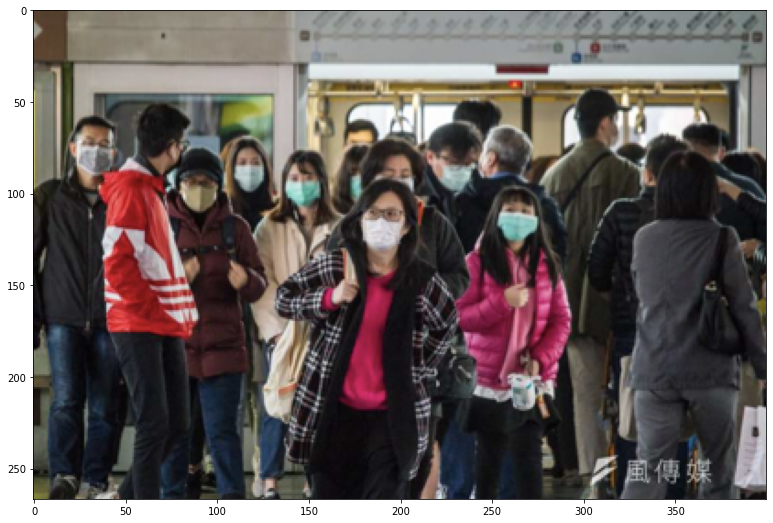

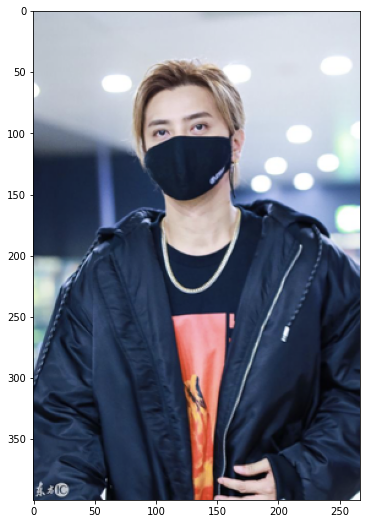

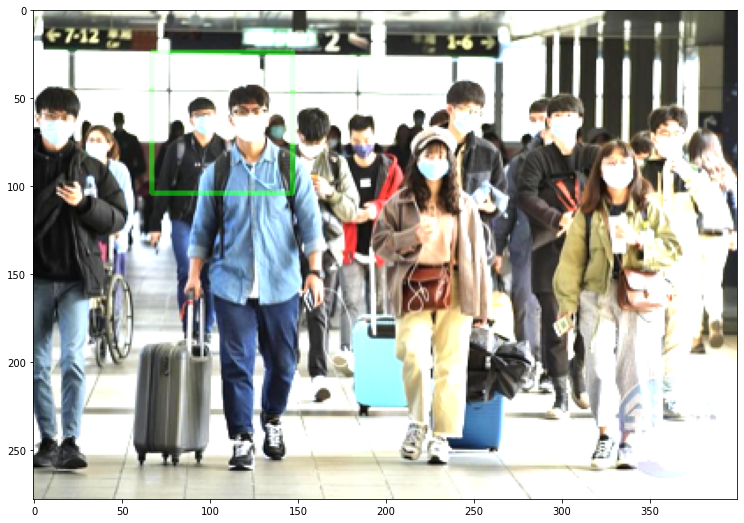

In [26]:
show_random_results(modelRSN18, 5)

### *2.2. YOLOv3*

#### Defining the model

#### Training the model

#### Saving the model

#### Testing the model